In [1]:
import sys
sys.path.insert(0,'..')
from paths import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
from tqdm import tqdm
from scipy.stats import ttest_ind, pearsonr

from IPython.display import clear_output


/Users/karthiksoman/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Load untargeted metabolomics data

In [2]:
sample = "serum"

if sample == "serum":
    filename = GLOBAL_SERUM_DATA_FILENAME
else:
    filename = GLOBAL_STOOL_DATA_FILENAME
    

file_path = os.path.join(DATA_ROOT_PATH, filename)

sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]

analyte_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])
patient_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[1])
data = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[2])

data.head()

patient_metadata.loc[:, "site_code"] = patient_metadata["CLIENT_SAMPLE_ID"].apply(lambda x:x[0:3])



## Analyte selection

In [3]:
global_metabolomics_compound_spoke_map = pd.read_csv(os.path.join(os.path.dirname(OUTPUT_PATH), "global_metabolomics_compound_spoke_map.csv"))

analyte_columns = list(data.columns)
analyte_columns.remove("PARENT_SAMPLE_NAME")

analyte_columns_selected = global_metabolomics_compound_spoke_map[global_metabolomics_compound_spoke_map.CHEM_ID.isin(analyte_columns)]["CHEM_ID"].unique()

data_with_analyte_columns_selected = data[["PARENT_SAMPLE_NAME"]+list(analyte_columns_selected)]


## Merging patient metadata with analyte concentration data

In [10]:
selected_metadata_columns = ["PARENT_SAMPLE_NAME", "CLIENT_IDENTIFIER", "GROUP_NAME", "AGE", "BMI", "GENDER", "CLIENT_SAMPLE_ID", "CLIENT_MATRIX", "TREATMENT", "SAMPLE_AMOUNT_UNITS"]
patient_metadata_selected_columns = patient_metadata[selected_metadata_columns]
# patient_metadata_selected_columns.loc[:, 'house'] = (patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[:3] + patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[-4:])
patient_metadata_selected_columns.loc[:, 'site'] = patient_metadata_selected_columns.loc[:, 'CLIENT_SAMPLE_ID'].str[:3]


data_with_patient_metadata = pd.merge(data_with_analyte_columns_selected, patient_metadata_selected_columns, on="PARENT_SAMPLE_NAME")

selected_metadata_columns.append('site')

clear_output()

data_with_patient_metadata.head()
# data_with_patient_metadata = data_with_patient_metadata[data_with_patient_metadata['CLIENT_SAMPLE_ID'].str.startswith('714')]


,PARENT_SAMPLE_NAME,35,50,62,93,98,111,112,117,144,...,CLIENT_IDENTIFIER,GROUP_NAME,AGE,BMI,GENDER,CLIENT_SAMPLE_ID,CLIENT_MATRIX,TREATMENT,SAMPLE_AMOUNT_UNITS,site
0,UCSF-06758,0.589314,-0.396834,-0.313341,0.851420,-0.739952,-0.544856,0.874154,-0.240343,0.562101,...,FS02495617,MS,52.0,19.422970,F,71701-0004,serum,Treated,uL,717
1,UCSF-06759,0.049593,0.139420,-0.159880,0.238199,-0.249942,-0.490267,-0.172927,-1.654431,-0.540335,...,FS02495625,MS,51.0,25.501750,F,71601-0150,serum,Off,uL,716
2,UCSF-06760,-0.416035,-1.045957,-0.740068,0.530813,-0.135617,-0.911855,-0.459714,-1.654431,-0.672326,...,FS02495633,Control,52.0,34.970939,M,71602-0150,serum,Control,uL,716
3,UCSF-06761,-0.386523,0.151742,0.580034,0.368174,0.307989,0.387318,0.176586,-0.504245,0.127822,...,FS02495641,MS,56.0,26.544467,M,71601-0164,serum,Treated,uL,716
4,UCSF-06762,-0.352323,-0.064386,0.691759,0.359623,-0.057788,-0.368919,0.571490,0.070276,-0.425296,...,FS02495649,Control,53.0,31.176140,F,71602-0164,serum,Control,uL,716


In [11]:
data_with_patient_metadata.shape

(1000, 1217)

## Loading JHU prediction data

In [12]:
jhu_prediction_data = pd.read_csv(os.path.join(DATA_ROOT_PATH, 'john_hopkins', 'Pred_levels_for_Karthik.csv'))


## Extracting ids for ILA and IAA

In [13]:
ila_chem_id = analyte_metadata[analyte_metadata['CHEMICAL_NAME'].str.startswith('indolelactate')].CHEM_ID.values[0]
iaa_chem_id = analyte_metadata[analyte_metadata['CHEMICAL_NAME'].str.startswith('indoleacetate')].CHEM_ID.values[0]



## Extracting ILA and IAA iMSMS data

In [14]:
ila_iaa_imsms_data = data_with_patient_metadata[['CLIENT_SAMPLE_ID', ila_chem_id, iaa_chem_id]]


## Merging JHU predictions with iMSMS data (ILA and IAA)

In [15]:

jhu_imsms_data = pd.merge(ila_iaa_imsms_data, jhu_prediction_data, left_on='CLIENT_SAMPLE_ID', right_on='iMSMS_ID') 
jhu_imsms_data = jhu_imsms_data.rename(columns={ila_chem_id:'exp_ILA', iaa_chem_id:'exp_IAA'})
jhu_imsms_data.loc[:,'exp_ratio'] = jhu_imsms_data.exp_ILA - jhu_imsms_data.exp_IAA


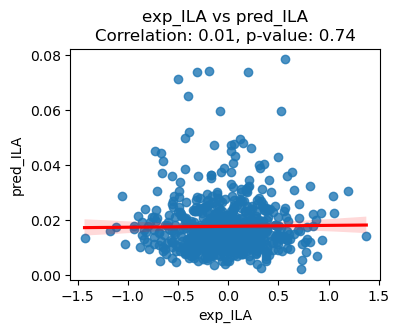

Saving the figure ...


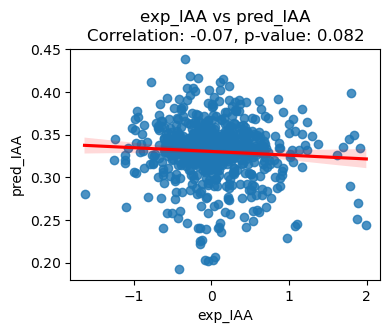

Saving the figure ...


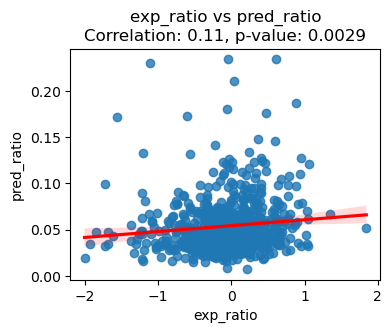

Saving the figure ...


In [16]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
def plot_with_regression(exp_col, pred_col, data, remove_exp_outliers=False, save=False):
    data = data[[exp_col, pred_col]].replace([np.inf, -np.inf], np.nan).dropna()
    if remove_exp_outliers:
        data = remove_outliers_iqr(data, exp_col)
    correlation, p_value = pearsonr(data[exp_col], data[pred_col])
    
    fig = plt.figure(figsize=(4, 3))
    sns.regplot(x=exp_col, y=pred_col, data=data, line_kws={'color': 'red'})
    
    plt.title(f'{exp_col} vs {pred_col}\n'
              f'Correlation: {correlation:.2f}, p-value: {p_value:.2g}')
    
    plt.xlabel(exp_col)
    plt.ylabel(pred_col)
    plt.show()
    if save:
        print('Saving the figure ...')
        fig_filename = os.path.join(DATA_ROOT_PATH, 'john_hopkins', 'figures', f'{exp_col}_vs_{pred_col}_{sample}_ucsf_cohort.tiff')
        fig.savefig(fig_filename, format='tiff', bbox_inches='tight')


columns = ['ILA', 'IAA', 'ratio']

for col in columns:
    exp_col = f'exp_{col}'
    pred_col = f'pred_{col}'
    plot_with_regression(exp_col, pred_col, jhu_imsms_data, remove_exp_outliers=False, save=True)


In [17]:
jhu_imsms_data.shape

(698, 12)